In [6]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import figure
import matplotlib.gridspec as gridspec
from ansim_dataset_unconf import ansimDataset, create_circular_mask, ansimDataset_orientation
from ConvLSTM_unconf import MtConvLSTM
import random
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import os
import scipy.ndimage
import cv2
import scipy.misc
from array2gif import write_gif
from scipy.misc import imsave
from numpy import linalg as LA
from sklearn.decomposition import PCA

In [7]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [8]:
img_path = '/home/rliu/ansim/data/unconfined_steph/cropped_orientation/'
img_list_csv = '/home/rliu/github/ansim/unconfined_orientation/img_list.csv'
train_csv = '/home/rliu/github/ansim/unconfined_orientation/train_unconf.csv'
test_csv = '/home/rliu/github/ansim/unconfined_orientation/test_unconf.csv'
# output_path = '/home/rliu/ansim/models/dataset3/6-17_mt_paper_orientation/final.weights'

img_path_r = '/home/rliu/ansim/data/unconfined_steph/cropped_retardance/'
img_list_csv = '/home/rliu/github/ansim/unconfined_orientation/img_list.csv'
train_csv = '/home/rliu/github/ansim/unconfined_orientation/train_unconf.csv'
test_csv = '/home/rliu/github/ansim/unconfined_orientation/test_unconf.csv'
# output_path_o = '/home/rliu/ansim/models/dataset3/6-17_mt_paper_retardance/final.weights'

In [12]:
mask = create_circular_mask(128,128)
orientation_set = ansimDataset_orientation(img_list_csv = img_list_csv, seq_csv = test_csv, root_dir = img_path, step=20, random_rotate = False, transform=None, image_size = 128, rand_range=0)
orientation_loader = torch.utils.data.DataLoader(orientation_set, batch_size=1, shuffle=False,
                                                     num_workers=1)

retardance_set = ansimDataset(img_list_csv = img_list_csv, seq_csv = test_csv, root_dir = img_path_r, step=20, random_rotate = False, transform=None, image_size = 128, rand_range=0)
retardance_loader = torch.utils.data.DataLoader(retardance_set, batch_size=1, shuffle=False,
                                                     num_workers=1)

In [13]:
model = torch.load('/home/rliu/ansim/models/dataset3/6-19_mt_paper_orientation/0240.weights')
model = model.module

In [14]:
dataiter = iter(orientation_loader)
index = 1
for i in range(index):
    images = dataiter.next()
    data_split = torch.split(images, (5,15), dim=1)
    inputs_t = data_split[0]
    target_t = data_split[1]
    inputs_t, target_t = inputs_t.cuda(), target_t.cuda()
# _, _, _, predicted_t = model(inputs_t)

dataiter = iter(retardance_loader)
for i in range(index):
    images_r = dataiter.next()
    data_split_r = torch.split(images_r, (5,15), dim=1)
    inputs_t_r = data_split_r[0]
    target_t_r = data_split_r[1]
    inputs_t_r, target_t_r = inputs_t_r.cuda(), target_t_r.cuda()

In [15]:
layer_output_list, last_state_list, pred_output, pred_a = model(inputs_t)

In [16]:
a = (layer_output_list, last_state_list, pred_output, pred_a)
with open('data.pickle', 'wb') as f:
    pickle.dump(a, f)
with open('data.pickle', 'rb') as f:
    a = pickle.load(f)
(layer_output_list, last_state_list, pred_output, pred_a) = a 
_,_,_, pred_b = model.forecast(layer_output_list, last_state_list, pred_output, pred_a, predict_steps = 10)

In [18]:
pred_t = torch.cat((pred_a, pred_b), 1)

In [24]:
predicted = pred_t[0,:,:,:,:].cpu().detach().numpy()
target = target_t[0,:,:,:,:].cpu().detach().numpy()
inputs = inputs_t[0,:,:,:,:].cpu().detach().numpy()

target_r = target_t_r[0,:,:,:,:].cpu().detach().numpy()
inputs_r = inputs_t_r[0,:,:,:,:].cpu().detach().numpy()

In [25]:
predicted_gf = np.zeros(predicted.shape)
target_gf = np.zeros(target.shape)
inputs_gf = np.zeros(inputs.shape)

inputs_gf[:,0,:,:] = np.sqrt(inputs[:,0,:,:] + 1/2)
inputs_gf[:,1,:,:] = inputs[:,1,:,:] / inputs_gf[:,0,:,:]

target_gf[:,0,:,:] = np.sqrt(target[:,0,:,:] + 1/2)
target_gf[:,1,:,:] = target[:,1,:,:] / target_gf[:,0,:,:]

predicted_gf[:,0,:,:] = np.sqrt(predicted[:,0,:,:] + 1/2)
predicted_gf[:,1,:,:] = predicted[:,1,:,:] / predicted_gf[:,0,:,:]

/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


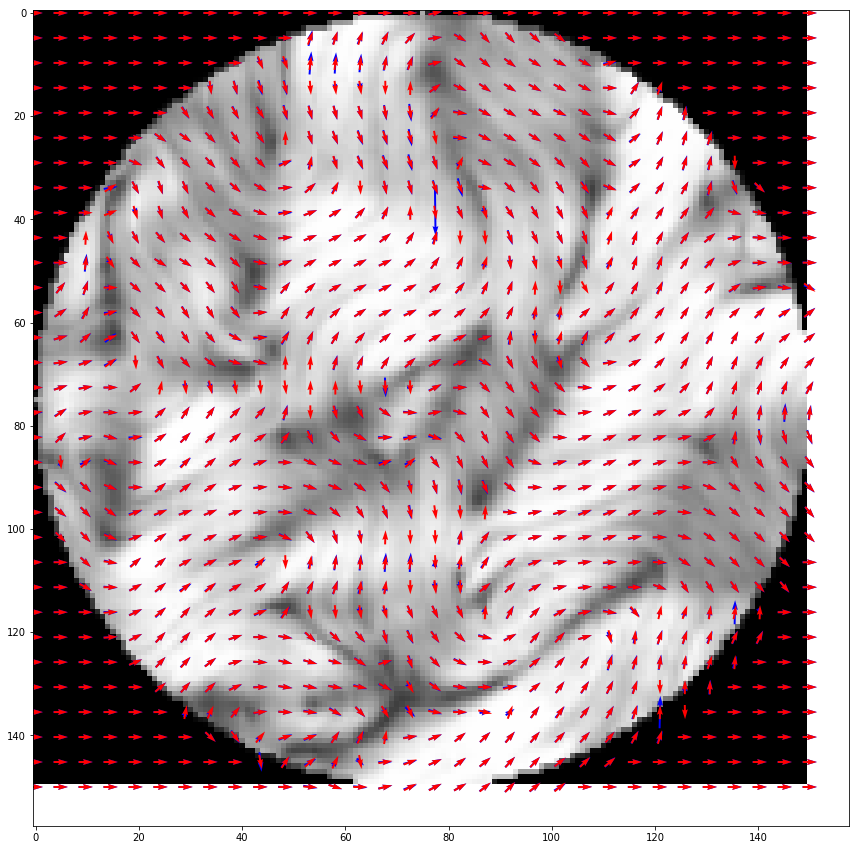

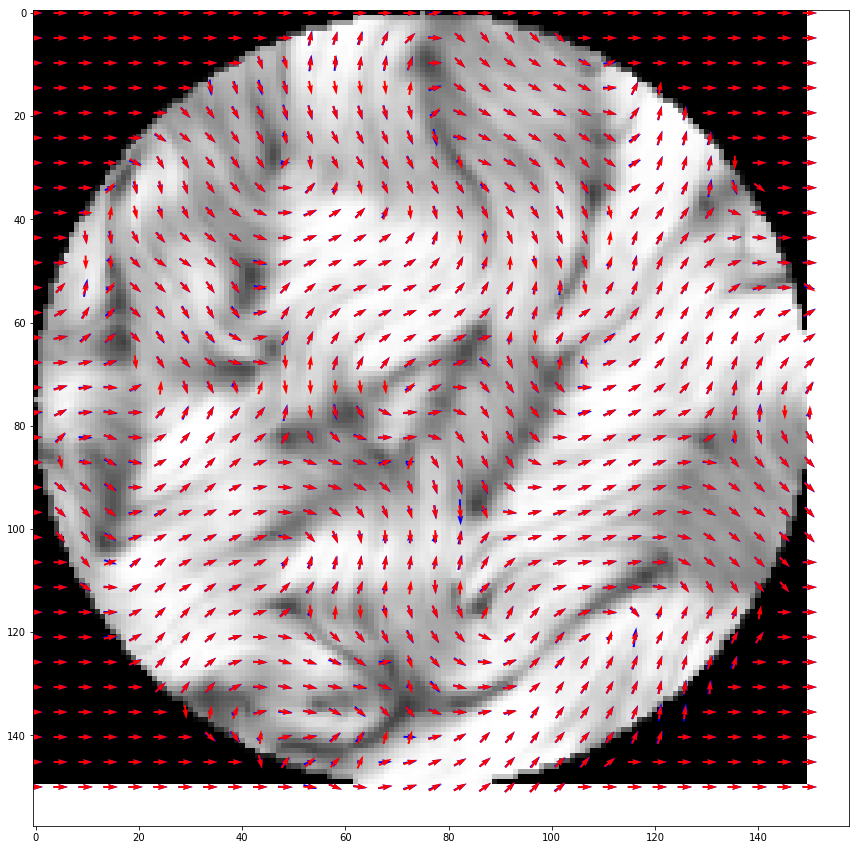

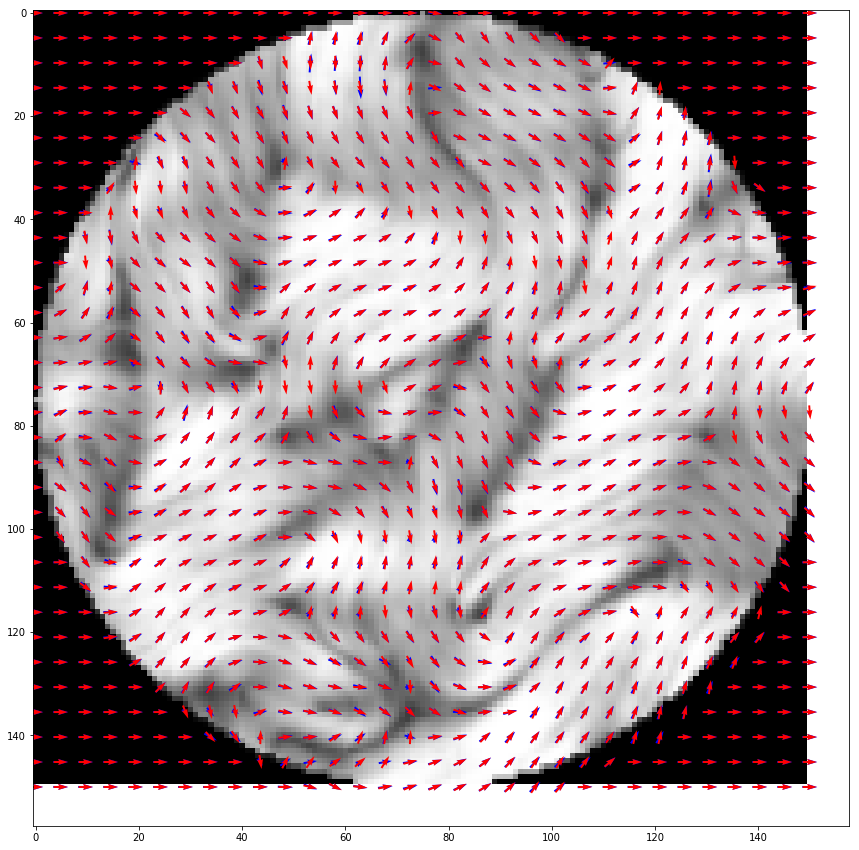

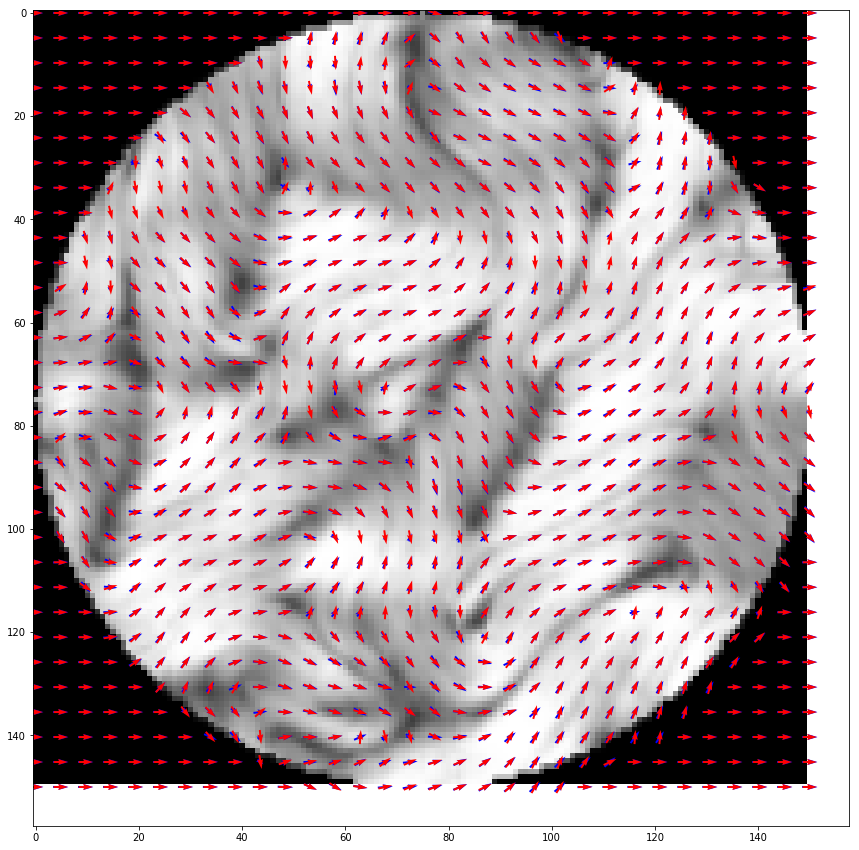

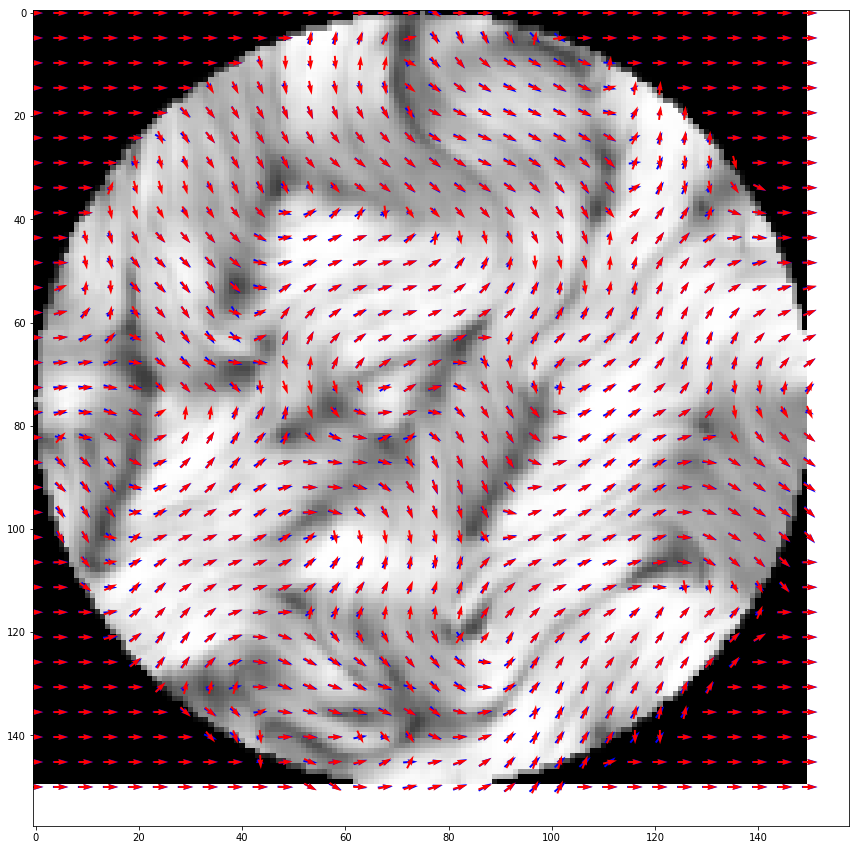

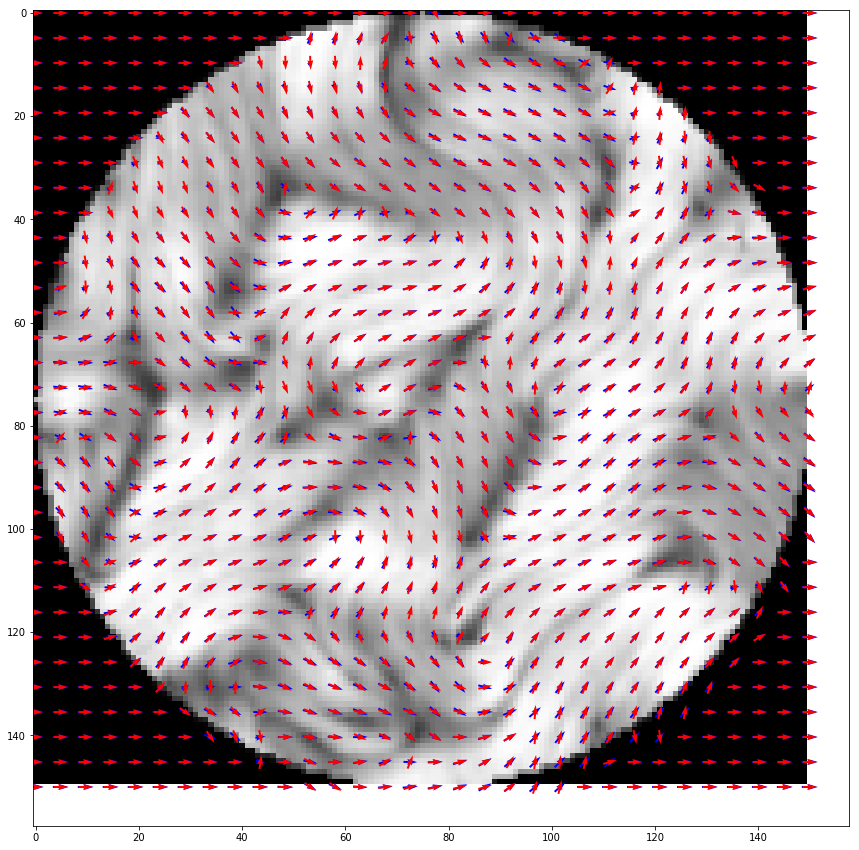

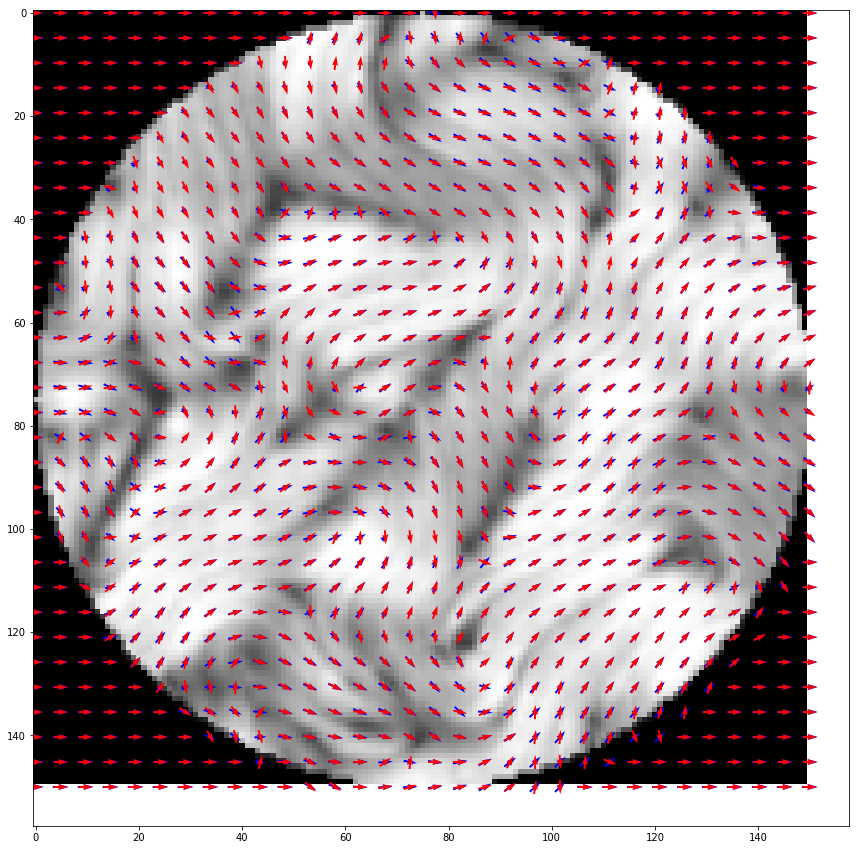

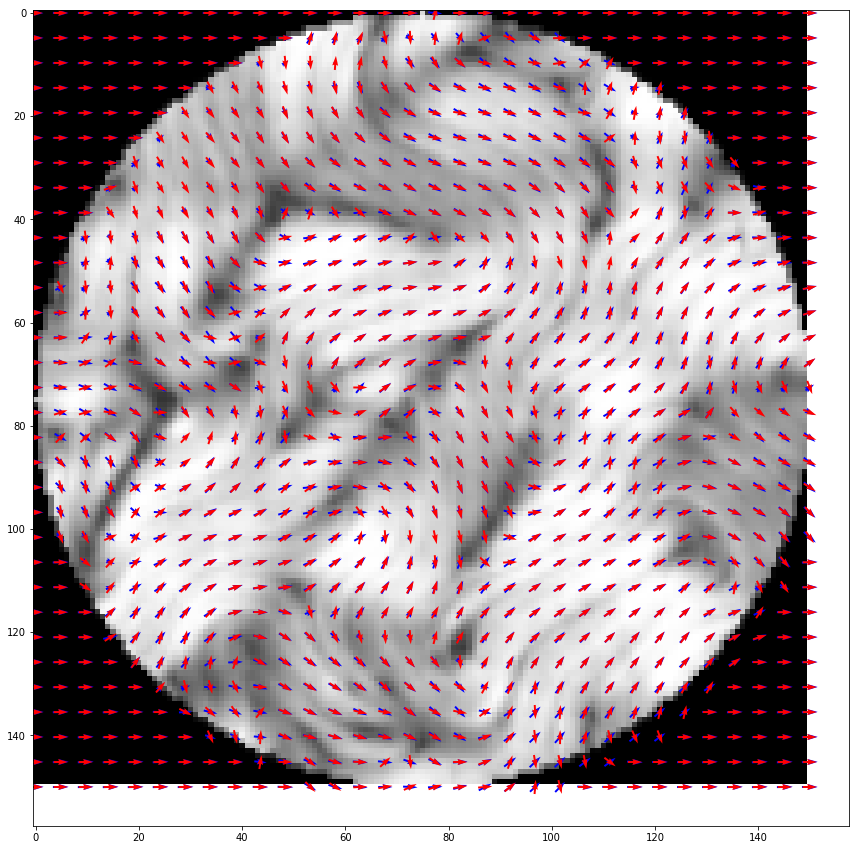

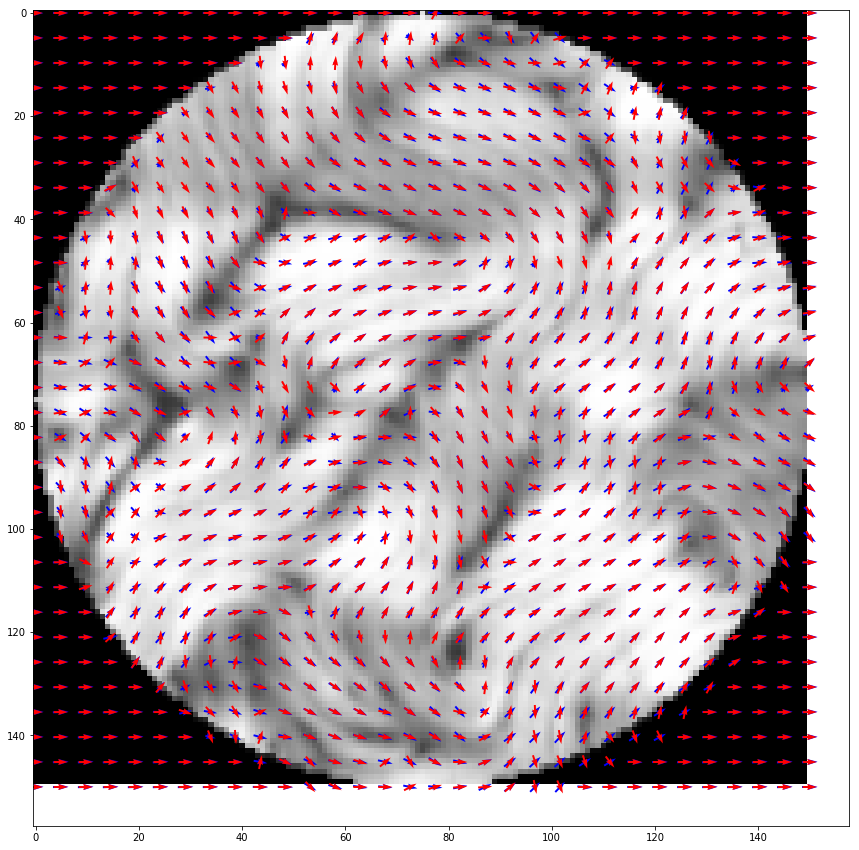

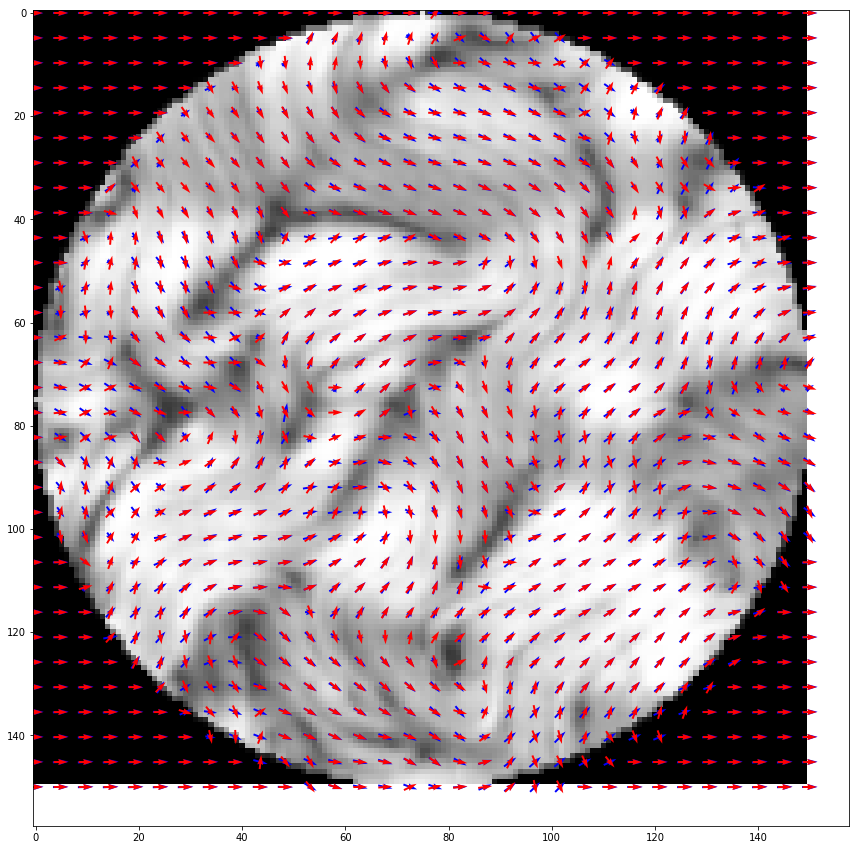

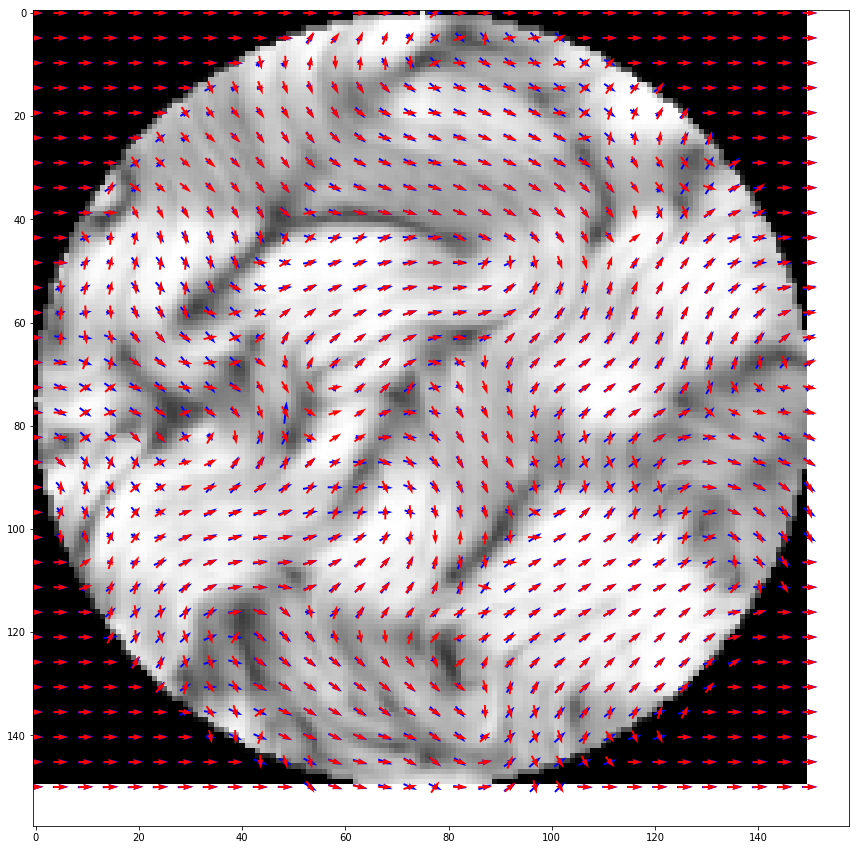

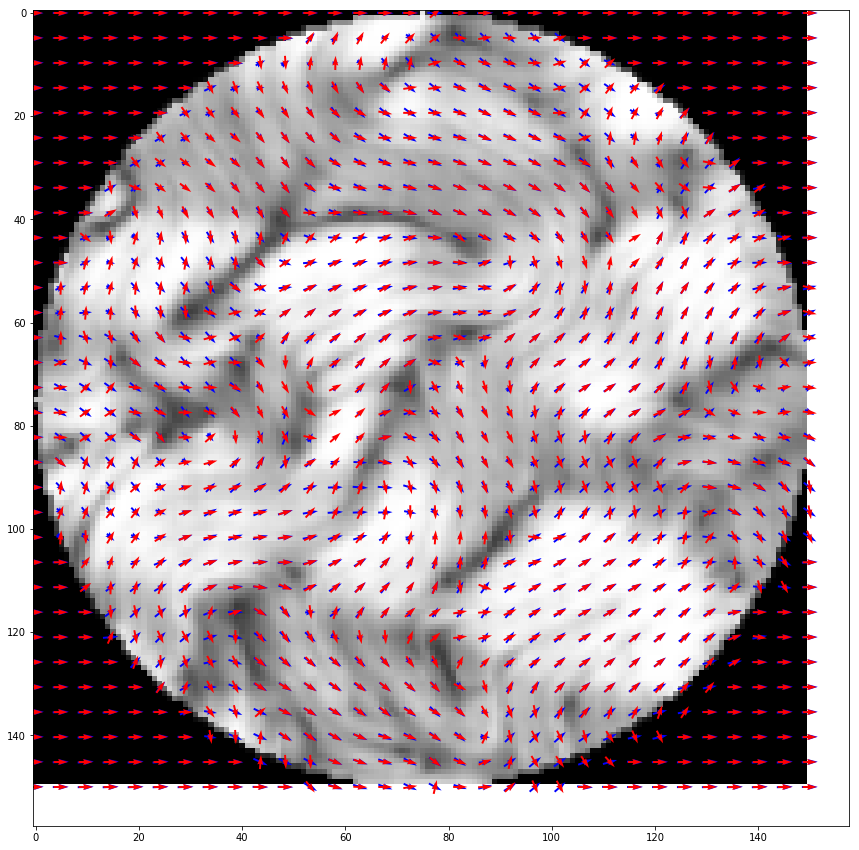

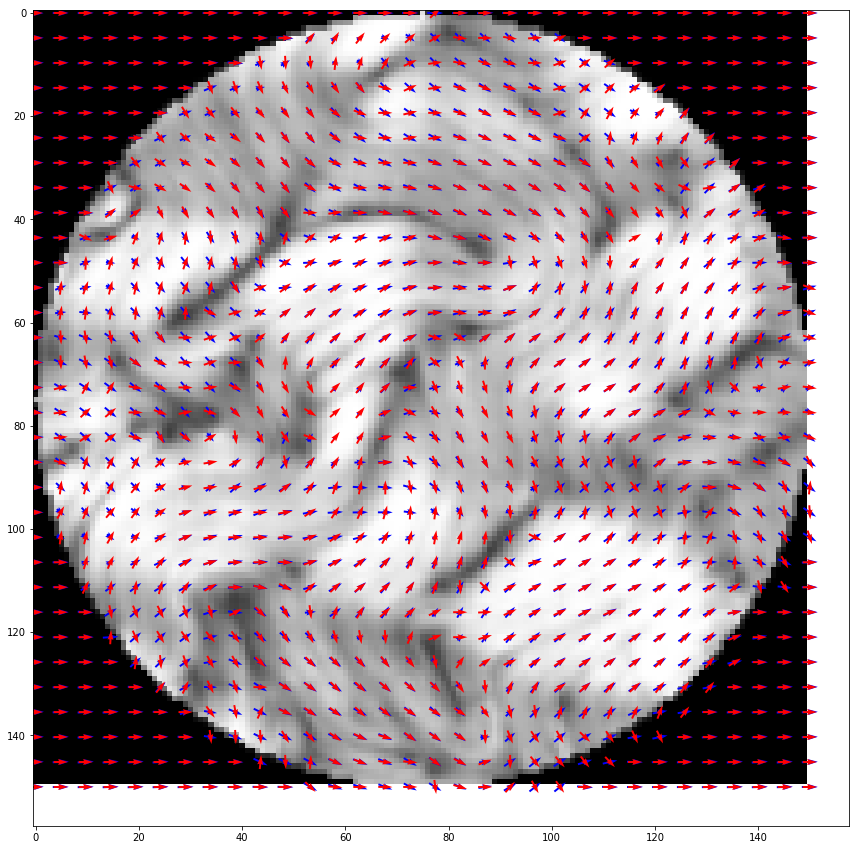

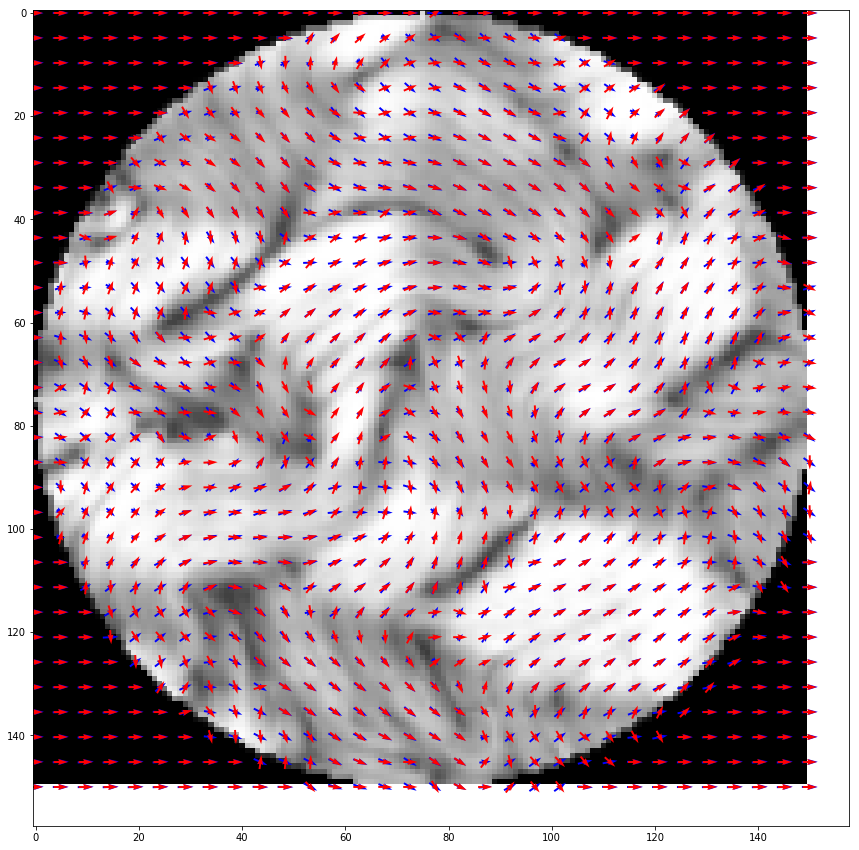

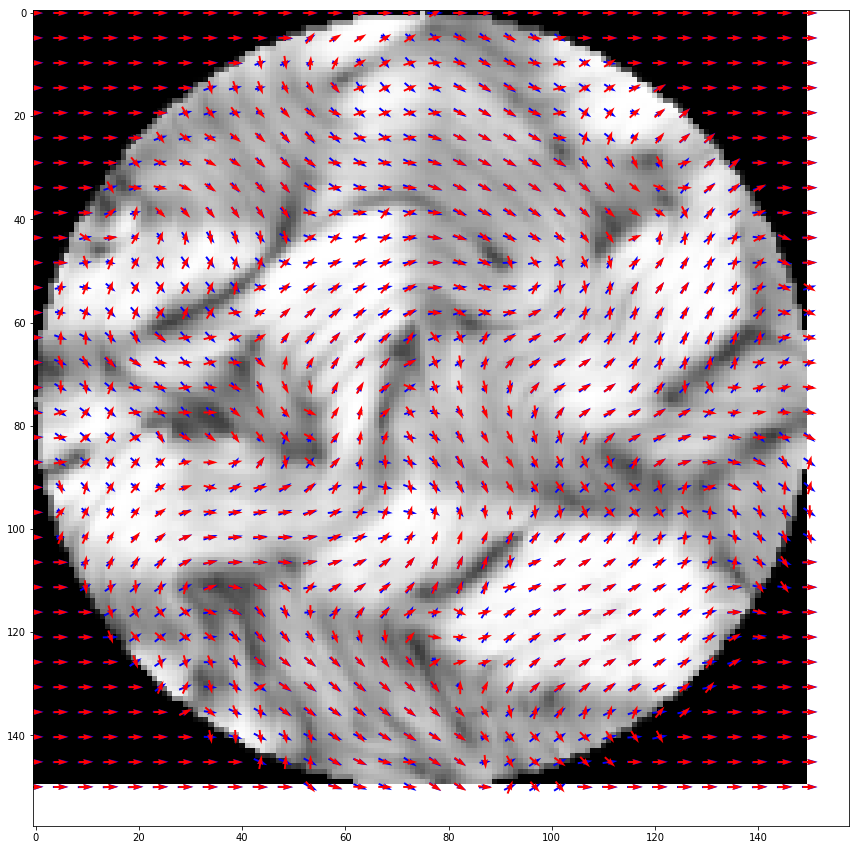

In [31]:
for index in range(15):
    img = target_r[index,0,:,:]
    size_gf = 32
    size_im = 150

    img = cv2.resize(img, (size_im,size_im),interpolation=cv2.INTER_LINEAR)

    U_predicted = predicted_gf[index,0,:,:]
    U_predicted = cv2.resize(U_predicted,(size_gf,size_gf),interpolation=cv2.INTER_NEAREST)
    V_predicted = predicted_gf[index,1,:,:]
    V_predicted = cv2.resize(V_predicted,(size_gf,size_gf),interpolation=cv2.INTER_NEAREST)

    U_target = target_gf[index,0,:,:]
    U_target = cv2.resize(U_target,(size_gf,size_gf),interpolation=cv2.INTER_NEAREST)
    V_target = target_gf[index,1,:,:]
    V_target = cv2.resize(V_target,(size_gf,size_gf),interpolation=cv2.INTER_NEAREST)

    nx, ny = (size_gf, size_gf)
    x = np.linspace(0, size_im, nx)
    y = np.linspace(0, size_im, ny)
    X, Y = np.meshgrid(x, y)
    fig = plt.figure(figsize=(15, 15))
    # gs = gridspec.GridSpec(nrows=10, ncols=10, height_ratios=[1, 1, 1])
    # ax0 = fig.add_subplot()
    plt.imshow(img,cmap='gray')

    # plt.streamplot(X,Y,U_predicted, V_predicted, color = 'blue', maxlength=4, minlength=0.05)
    # plt.streamplot(X,Y,U_target, V_target, color = 'red', maxlength=5, minlength=0.05)
    plt.quiver(X, Y, U_predicted, V_predicted, color = 'blue', pivot='middle')
    plt.quiver(X, Y, U_target, V_target, color = 'red', pivot='middle')
    fig.savefig('/home/rliu/ansim/results/orientation_6-24/%0.6d.png' % index)

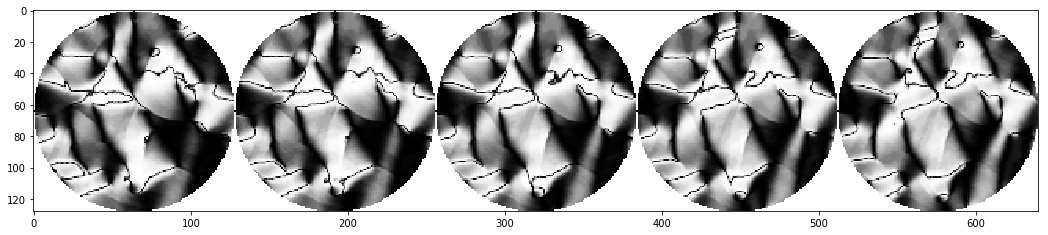

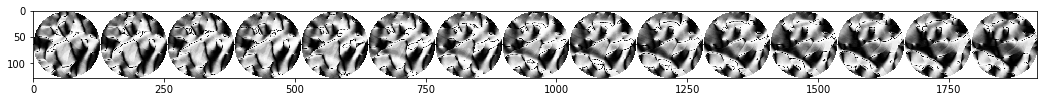

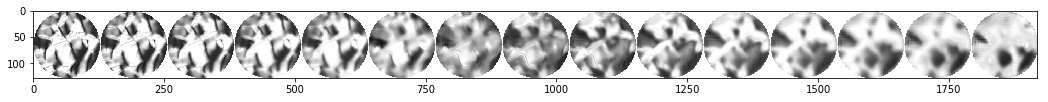

In [16]:
pred_t = torch.cat((pred_a, pred_b), 1)
predicted = pred_t[0,:,0,:,:].cpu().detach().numpy()
target = target_t[0,:,0,:,:].cpu().detach().numpy()
inputs = inputs_t[0,:,0,:,:].cpu().detach().numpy()

inputs = (inputs + 0.5) * 255
target = (target + 0.5) * 255
predicted = (predicted + 0.5) * 255

inputs = inputs.reshape(640,128).transpose().astype(int)
target = target.reshape(1920,128).transpose().astype(int)
predicted = predicted.reshape(1920,128).transpose().astype(int)

inputs = inputs - inputs.min()
target = target - target.min()
predicted = predicted - predicted.min()

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(inputs, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(target, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(predicted, interpolation='nearest', cmap='gray', vmin=0, vmax=255)